100%|██████████| 170M/170M [00:05<00:00, 32.0MB/s]


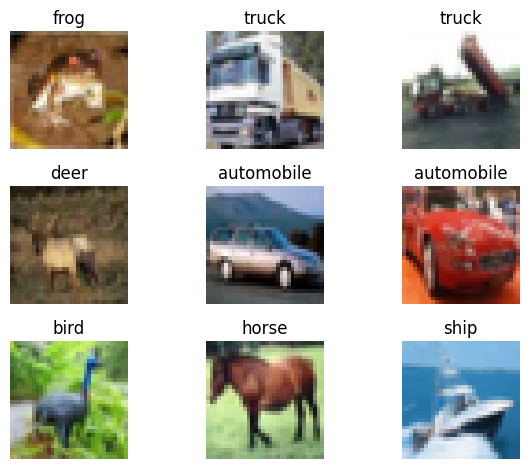

In [1]:
import matplotlib.pyplot as plt

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

#CIFAR10 데이터셋을 불러옴
training_data = CIFAR10(
    root="./",#현재 디렉토리에 데이터셋을 불러옴
    train=True,
    download=True,
    transform=ToTensor())#이미지를 파이토치 텐서로 변환해줌

test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=ToTensor())

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(training_data.data[i])
    plt.title(training_data.classes[training_data.targets[i]])#label 표시
    plt.axis('off')  # 축 안 보이게
plt.tight_layout()
plt.show()


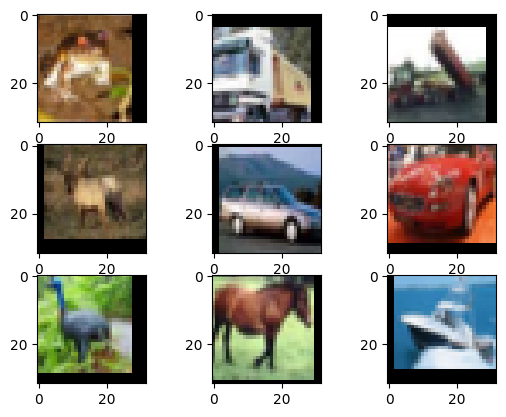

In [2]:
#데이터 증강

import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

transforms = Compose([ #데이터 전처리 함수들
   T.ToPILImage(), # numpy → PIL 이미지로 변환
   RandomCrop((32, 32), padding=4), # 4픽셀 패딩 후 32x32로 랜덤 자르기
   RandomHorizontalFlip(p=0.5),     #y축으로 기준으로 대칭, 50% 확률로
])

training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=transforms) # transform에는 데이터를 변환하는 함수가 들어감

test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=transforms)

for i in range(9):
   plt.subplot(3, 3, i+1)
   plt.imshow(transforms(training_data.data[i]))
plt.show()

In [3]:
import torch

#이미지 정규화를 하기 위한 사전 작업

training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=ToTensor())

# item[0]은 이미지, item[1]은 정답 레이블 -> 이미지만 추출
imgs = [item[0] for item in training_data]

# imgs를 하나로 합침
imgs = torch.stack(imgs, dim=0).numpy()

# rgb 각각의 평균
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r,mean_g,mean_b)

# rgb 각각의 표준편차
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r,std_g,std_b)

0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


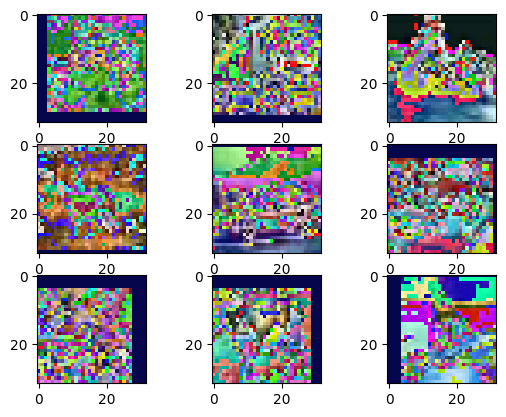

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize

transforms = Compose([
   T.ToPILImage(),
   RandomCrop((32, 32), padding=4),
   RandomHorizontalFlip(p=0.5),
   T.ToTensor(),# PIL 이미지 → Tensor (0~1 정규화됨)
   #데이터 정규화
   Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),#R, G, B 채널별 정규화(방금 전에 구한 값을 기준으로)
   T.ToPILImage()# 다시 PIL 이미지로 변환해서 plt.imshow()에 보여줄 수 있게 함
])

training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=transforms)
test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=transforms)

for i in range(9):
   plt.subplot(3, 3, i+1)
   plt.imshow(transforms(training_data.data[i]))
plt.show()

In [5]:
import torch
import torch.nn as nn


#기본 블록: Conv2d → ReLU → Conv2d → ReLU → MaxPool

class BasicBlock(nn.Module): #기본 블록을 정의함. -> 큰 네트워크의 구성 요소
   # 기본블록을 구성하는 계층의 정의
   def __init__(self, in_channels, out_channels, hidden_dim):
       #nn.Module 클래스의 요소 상속
       super(BasicBlock, self).__init__()

       #합성곱층 정의
       self.conv1 = nn.Conv2d(in_channels, hidden_dim,
                              kernel_size=3, padding=1)
       self.conv2 = nn.Conv2d(hidden_dim, out_channels,
                              kernel_size=3, padding=1)
       self.relu = nn.ReLU()

       # stride는 커널의 이동 거리를 의미합니다.
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

   def forward(self, x): #기본블록의 순전파 정의
       x = self.conv1(x)
       x = self.relu(x)
       x = self.conv2(x)
       x = self.relu(x)
       x = self.pool(x)

       return x#기본 블록을 통과한 최종 결

In [6]:
#입력 이미지 → 기본블록 1 → 기본블록 2 → 기본블록 3 → Flatten → FC1 → ReLU → FC2 → ReLU → FC3 → 최종 클래스 예측


class CNN(nn.Module):
   def __init__(self, num_classes): # num_classes는 클래스의 개수를 의미합니다: 10
       super(CNN, self).__init__()

       #합성곱 기본 블록의 정의
       #각 블록마다 채널의 수가 늘어나고, maxPool 거치면서 feature map 크기가 절반씩 줄어듦
       self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
       self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
       self.block3 = BasicBlock(in_channels=128, out_channels=256, hidden_dim=128)

       #분류기 정의
       self.fc1 = nn.Linear(in_features=4096, out_features=2048)
       self.fc2 = nn.Linear(in_features=2048, out_features=256)
       self.fc3 = nn.Linear(in_features=256, out_features=num_classes)

       #분류기의 활성화 함수
       self.relu = nn.ReLU()

   def forward(self, x):
       x = self.block1(x)
       x = self.block2(x)
       x = self.block3(x)  # 출력 모양: (-1, 256, 4, 4)
       x = torch.flatten(x, start_dim=1) #2차원 특징맵을 1차원으로

       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
       x = self.relu(x)
       x = self.fc3(x)

       return x

In [7]:
from torch.utils.data.dataloader import DataLoader

from torch.optim.adam import Adam

train_transforms = Compose([
   RandomCrop((32, 32), padding=4),  #주변에 4픽셀 추가한 후, 32*32 크기로 랜덤 크롭핑
   RandomHorizontalFlip(p=0.5),  #50% 확률로 y축으로 뒤집기
   ToTensor(),  #텐서로 변환(픽셀값 범위를 정규화함)
   #이미지 정규화(R, G, B 각 채널별)
   Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

In [8]:
test_transform = Compose([
    ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

In [9]:
#학습 데이터와 평가 데이터 불러오기
#transform = transforms 사용하면서 데이터의 증강이 적용됨.
#실제 저장공간에서의 데이터 수가 늘어나나? no. 하지만 매 epoch에서 랜덤한 변화가 생기면서 다양한 모습의 데이터를 볼 수 있음.
training_data = CIFAR10(root="./", train=True, download=True, transform=train_transforms)

#test데이터는 평가용이므로, 원본 데이터로 측정해야 함.
test_data = CIFAR10(root="./", train=False, download=True, transform=test_transform)


#데이터로더 정의
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


#학습을 진행할 프로세서 설정
device = "cuda" if torch.cuda.is_available() else "cpu"


#CNN 모델 정의
model = CNN(num_classes=10)

#모델을 device로 보냄
model.to(device)

CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

In [10]:
#학습률 정의
lr = 1e-3

#최적화 기법 정의
optim = Adam(model.parameters(), lr=lr)

# 학습 루프 정의
for epoch in range(1):#시간관계상 1
   for data, label in train_loader:  #데이터 호출
       optim.zero_grad()  #기울기 초기화

       preds = model(data.to(device))  #모델의 예측

       #오차역전파와 최적화
       loss = nn.CrossEntropyLoss()(preds, label.to(device))
       loss.backward()#오차 역전파
       optim.step()#가중치 업데이트

   if epoch==0 or epoch%10==9:  # 10번마다 손실 출력
       print(f"epoch{epoch+1} loss:{loss.item()}")


# 모델 저장
torch.save(model.state_dict(), "CIFAR.pth")

epoch1 loss:1.5562677383422852


In [11]:
model.load_state_dict(torch.load("CIFAR.pth", map_location=device))

num_corr = 0

with torch.no_grad():#평가시에 연산량 절약하기 위해서 gradient 계산 생략함
   for data, label in test_loader:

       output = model(data.to(device))
       preds = output.data.max(1)[1]#가장 높은 확률의 클래스
       corr = preds.eq(label.to(device).data).sum().item()#정답과 비교하여 맞춘 개수를 셈
       num_corr += corr

   print(f"Accuracy:{num_corr/len(test_data)}")

Accuracy:0.5468
